In [98]:
import pandas as pd
import matplotlib.pyplot as plt

#### Read in Data

In [42]:
def read_ts(csv):
    df = pd.read_csv(
        f'data/{csv}.csv', 
        usecols = ['month', 'total.total'],
        parse_dates=['month'])
    df.index = df['month'].dt.to_period()
    df.drop(columns = 'month', inplace = True)
    df.columns = [csv]
    return df[csv]

In [43]:
editors = read_ts('editors')
total_views = read_ts('total_views')
legacy_views = read_ts('legacy_views')

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [44]:
editors.head()
legacy_views.head()
total_views.head()

month
2016-01    9330869593
2016-02    8684367374
2016-03    8802611656
2016-04    8932908573
2016-05    8816345693
Freq: M, Name: total_views, dtype: int64

In [45]:
editors.info()

<class 'pandas.core.series.Series'>
PeriodIndex: 253 entries, 2001-01 to 2022-01
Freq: M
Series name: editors
Non-Null Count  Dtype
--------------  -----
253 non-null    int64
dtypes: int64(1)
memory usage: 4.0 KB


### Merge Data

#### Combine legacy and total views to one series

In [59]:
merged_views = pd.DataFrame({'legacy': legacy_views, 'total_views': total_views})
merged_views.sample(10)

,legacy,total_views
2014-12,9.109282e+09,NaN
2011-03,7.326546e+09,NaN
2021-11,NaN,8.668084e+09
2014-04,7.216245e+09,NaN
2010-03,6.661348e+09,NaN
2019-12,NaN,9.421143e+09
2016-11,NaN,9.292575e+09
2017-03,NaN,9.715995e+09
2012-01,7.808477e+09,NaN
2011-02,6.906249e+09,NaN


In [62]:
views = merged_views.max(axis = 1)
views

2007-12    2.998332e+09
2008-01    4.930903e+09
2008-02    4.818394e+09
2008-03    4.955406e+09
2008-04    5.159162e+09
               ...     
2021-09    9.217505e+09
2021-10    9.168265e+09
2021-11    8.668084e+09
2021-12    8.761074e+09
2022-01    9.676745e+09
Freq: M, Length: 170, dtype: float64

#### Add Editors

In [100]:
df = pd.DataFrame({'editors': editors, 'views': views})
df.head()

,editors,views
2001-01,110,NaN
2001-02,68,NaN
2001-03,164,NaN
2001-04,104,NaN
2001-05,139,NaN


### Plot Series

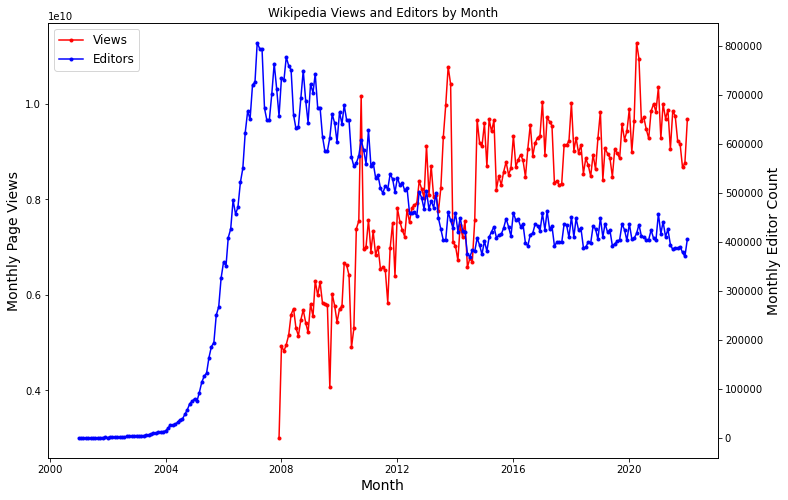

In [104]:
#Used https://pythonguides.com/matplotlib-two-y-axes/ as reference

plt.figure(figsize = (12, 8))

ax1 = plt.axes()
plot_1 = plt.plot(df['views'].to_timestamp(), '.-r', label = 'Views')
ax1.set_ylabel('Monthly Page Views', fontsize = 14)

ax2 = ax1.twinx()
plot_2 = plt.plot(df['editors'].to_timestamp(), '.-b', label = 'Editors')
ax2.set_ylabel("Monthly Editor Count", fontsize = 14)

ax1.set_xlabel('Month', fontsize = 14)
plt.title('Wikipedia Views and Editors by Month')

lns = plot_1 + plot_2
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc = 'upper left', fontsize = 12)
plt.show()

### Correlation tables

In [105]:
df.corr()

,editors,views
editors,1.00000,-0.77921
views,-0.77921,1.00000


In [108]:
df.diff().corr() # Change in editors is correlated with change in views

,editors,views
editors,1.000000,0.557582
views,0.557582,1.000000


### Auto correlations

In [113]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The auto correlation plot shows high correlations at all lags, indicating the data should be differenced first.
Additonally, the partial auto correlation plot confirms this by showing low partial auto correlations after the first term.

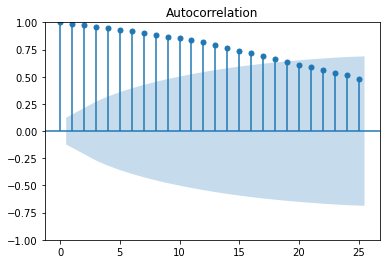

In [119]:
plot_acf(editors);

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


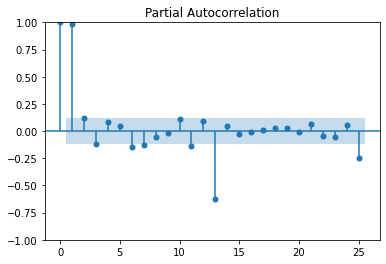

In [121]:
plot_pacf(editors);

After one difference, the auto correlation function is showing high correlation at lags 12 and 24.
This indicates a seasonal auto regressive component.

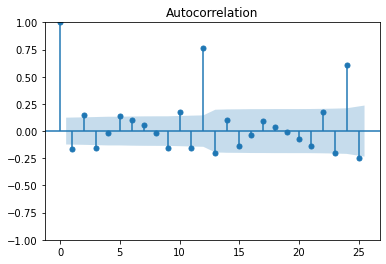

In [118]:
plot_acf(editors.diff()[1:]);

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


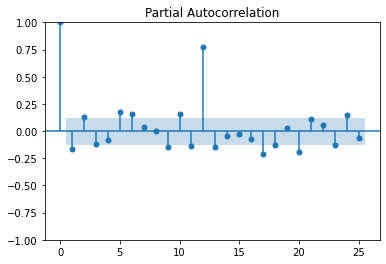

In [122]:
plot_pacf(editors.diff()[1:]);

These plots suggest a good sarima model is (0, 1, 0) x (1, 0, 0)

### Predicting number of editors

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
y= df['editors']
y_train, y_test = train_test_split(y, test_size=24, shuffle= False) # predict last 2 years

<AxesSubplot:>

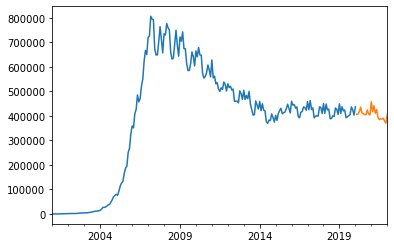

In [111]:
y_train.plot()
y_test.plot()

#### Baseline Model

#### Holt Winters

In [124]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [130]:
hw = ExponentialSmoothing(
    y_train,
    seasonal_periods = 12,
    trend = 'add',
    seasonal = 'mul',
    damped_trend = True
)
hw_results = hw.fit()
hw_results.summary()

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,editors,No. Observations:,229
Model:,ExponentialSmoothing,SSE,130964055353.998
Optimized:,True,AIC,4651.663
Trend:,Additive,BIC,4710.036
Seasonal:,Multiplicative,AICC,4655.299
Seasonal Periods:,12,Date:,"Fri, 25 Feb 2022"
Box-Cox:,False,Time:,13:10:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2525000,alpha,True
smoothing_trend,0.1983929,beta,True
